# OSSE/Trade Space Capability for NOAA's Future Mission Design

Small Tradespace Exploration

Paul T. Grogan <paul.grogan@asu.edu>

## Modeling NOAA's Future Observing Systems

### Introduction

The objective of this report is to model and comparatively evaluate future LEO observing systems derived from NOAA's program of record.

### Scenario Specification

The analysis scenario considers a 30-day period starting on September 9, 2023 at 0:00 UTC. Revisit analysis considers a global domain of target points distributed following a Fibonacci lattice with a 1000 km typical sample distance.

In [7]:
from datetime import datetime, timedelta, timezone
from tatc.generation import generate_fibonacci_lattice_points
from tatc.schemas import Point

start = datetime(year=2023, month=9, day=15, hour=0, minute=0, tzinfo=timezone.utc)

# generate a sample point distribution with 1000 km typical sample distance
points_df = generate_fibonacci_lattice_points(1000e3)

# convert the sample points dataframe to TAT-C format
points = points_df.apply(
    lambda r: Point(id=r.point_id, latitude=r.geometry.y, longitude=r.geometry.x),
    axis=1,
)

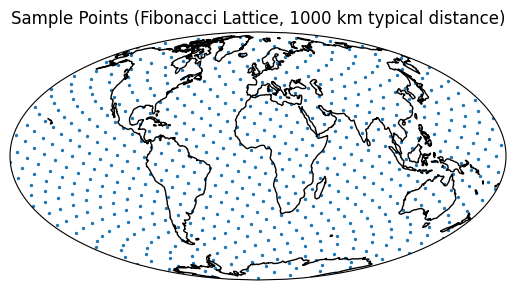

In [10]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# plot the sample points
ax = plt.axes(projection=ccrs.Mollweide())
points_df.plot(ax=ax, markersize=2, transform=ccrs.PlateCarree())
ax.coastlines()
plt.title("Sample Points (Fibonacci Lattice, 1000 km typical distance)")
plt.show()

### Revisit Analysis Function

This block defines a function to perform end-to-end revisit analysis for a new constellation.

In [24]:
from tatc.analysis import (
    collect_observations,
    aggregate_observations,
    reduce_observations,
)
from scipy import stats
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pandas as pd
from joblib import Parallel, delayed


def revisit_analysis(
    start, duration, satellites, points, unit=timedelta(hours=1), bins=None
):
    # parallel process observations for all points/satellites/instruments
    obs_db_list = Parallel(n_jobs=-1)(
        delayed(collect_observations)(
            point,
            satellite,
            instrument,
            start,
            start + duration,
        )
        for point in points
        for satellite in satellites
        for instrument in satellite.instruments
    )

    # merge the parallel-processed observation dataframes into a single dataframe
    obs_df = pd.concat(obs_db_list, ignore_index=True)

    # aggregate observations to combine overlapping observations
    agg_df = aggregate_observations(obs_df)
    # reduce observations to time-averaged statistics for each sample point
    red_df = reduce_observations(agg_df)
    red_df["revisit_u"] = red_df.apply(lambda r: r["revisit"] / unit, axis=1)
    unit_str = (
        "hr"
        if unit == timedelta(hours=1)
        else "min" if unit == timedelta(minutes=1) else "u"
    )

    # generate the figure
    fig = plt.figure()
    gs = GridSpec(nrows=3, ncols=1, figure=fig, height_ratios=[3, 1, 0.25])
    axs = [
        plt.subplot(gs[0, 0], projection=ccrs.Mollweide()),
        plt.subplot(gs[1, 0]),
        plt.subplot(gs[2, 0]),
    ]
    cmap = plt.colormaps["viridis"]
    plt.suptitle(f'Harmonic Mean={stats.hmean(red_df["revisit_u"]):.1f} {unit_str}')

    data = red_df["revisit_u"]
    values, bins, bars = axs[1].hist(
        data, weights=np.ones(len(data)) / len(data), bins=bins
    )
    centers = 0.5 * (bins[:-1] + bins[1:])
    colors = (centers - bins.min()) / (bins.max() - bins.min())
    for c, p in zip(colors, bars):
        plt.setp(p, "facecolor", cmap(c))
    axs[1].bar_label(bars, fmt="{:.1%}")
    axs[1].set_xlim(bins.min(), bins.max())
    axs[1].set_ylim(0, values.max() * 1.5)
    axs[1].axis("off")
    red_df.plot(
        ax=axs[0],
        column="revisit_u",
        cmap=cmap,
        vmin=bins.min(),
        vmax=bins.max(),
        legend=True,
        legend_kwds={
            "label": f"Revisit ({unit_str})",
            "orientation": "horizontal",
            "cax": axs[2],
            "ticks": bins,
            "format": StrMethodFormatter("{x:.1f}"),
        },
        transform=ccrs.PlateCarree(),
    )
    axs[0].coastlines()
    axs[0].set_global()

    # return the results
    return {
        "satellites": satellites,
        "revisit": stats.hmean(red_df["revisit_u"]),
        "fig": fig,
    }

### Program of Record

The program of record consists of two satellites in one plane, a 850 km sun-synchronous orbit with a 13:30 local time of ascending node (LTAN). For simplicity this analysis considers a microwave sounder with 2200 km cross-track swath width and 16 km sampling distance. The following function allows variation in the baseline program of record to modify altitude, number of satellites in the 13:30 LTAN orbit and number of satellites in a 05:30 LTAN orbit. 

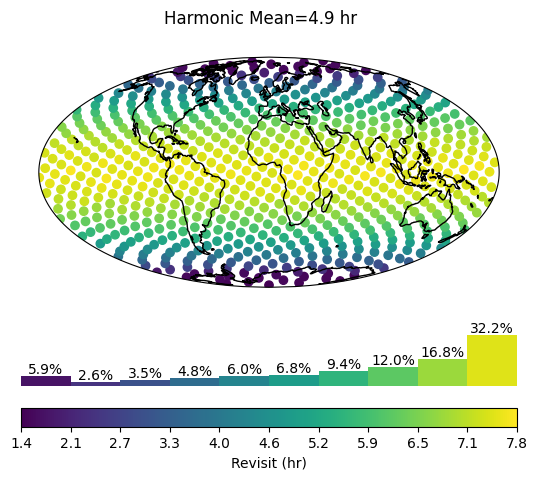

In [15]:
from tatc.schemas import WalkerConstellation, SunSynchronousOrbit, Instrument
from tatc.utils import (
    swath_width_to_field_of_regard,
    along_track_distance_to_access_time,
)


def program_of_record(altitude=850e3, num_satellites_1330=2, num_satellites_0530=0):
    orbit_1330 = SunSynchronousOrbit(
        altitude=altitude,
        epoch=start,
        equator_crossing_time="13:30",
        equator_crossing_ascending=True,
        true_anomaly=0,
    )
    sounder_1330 = Instrument(
        name="Microwave Sounder",
        field_of_regard=swath_width_to_field_of_regard(orbit_1330.altitude, 2200000),
        min_access_time=timedelta(
            seconds=along_track_distance_to_access_time(
                orbit_1330.altitude, orbit_1330.get_inclination(), 16000
            )
        ),
        access_time_fixed=True,
    )
    const_1330 = WalkerConstellation(
        name="13:30",
        orbit=orbit_1330,
        instruments=[sounder_1330],
        number_satellites=num_satellites_1330,
        number_planes=1,
    )
    if num_satellites_0530 == 0:
        return const_1330.generate_members()
    orbit_0530 = SunSynchronousOrbit(
        altitude=altitude,
        epoch=start,
        equator_crossing_time="05:30",
        equator_crossing_ascending=True,
        true_anomaly=0,
    )
    sounder_0530 = Instrument(
        name="MW Sounder",
        field_of_regard=swath_width_to_field_of_regard(orbit_0530.altitude, 2200000),
        min_access_time=timedelta(
            seconds=along_track_distance_to_access_time(
                orbit_0530.altitude, orbit_0530.get_inclination(), 16000
            )
        ),
        access_time_fixed=True,
    )
    const_0530 = WalkerConstellation(
        name="05:30",
        orbit=orbit_0530,
        instruments=[sounder_0530],
        number_satellites=num_satellites_0530,
        number_planes=1,
    )
    return const_1330.generate_members() + const_0530.generate_members()


results = revisit_analysis(start, timedelta(days=30), program_of_record(), points)

### Altitude Sensitivity Analysis

,satellites,revisit,fig
0,[name='13:30 1' orbit=CircularOrbit(altitude=4...,4.464131,Figure(640x480)
1,[name='13:30 1' orbit=CircularOrbit(altitude=5...,4.605577,Figure(640x480)
2,[name='13:30 1' orbit=CircularOrbit(altitude=7...,4.746637,Figure(640x480)
3,[name='13:30 1' orbit=CircularOrbit(altitude=8...,4.887888,Figure(640x480)
4,[name='13:30 1' orbit=CircularOrbit(altitude=1...,5.034685,Figure(640x480)


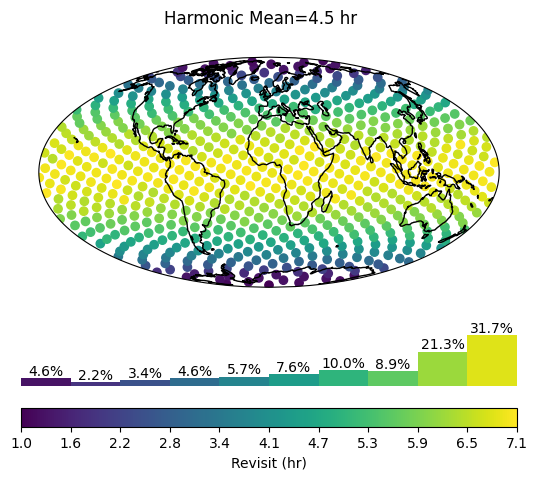

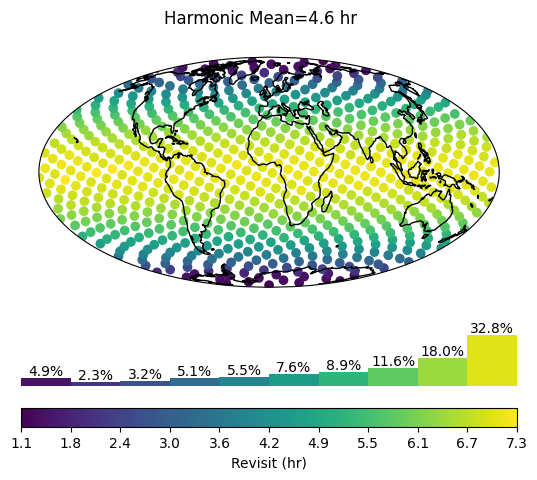

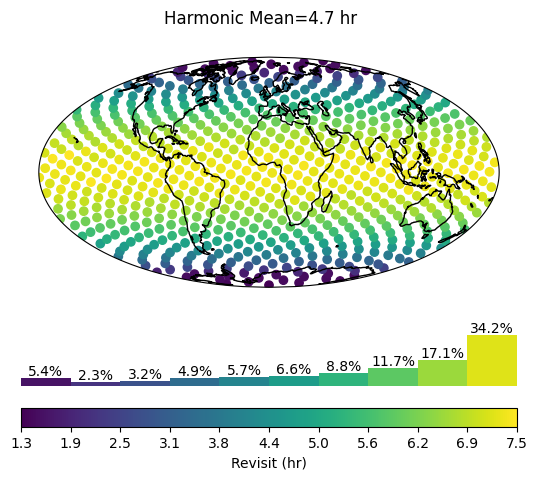

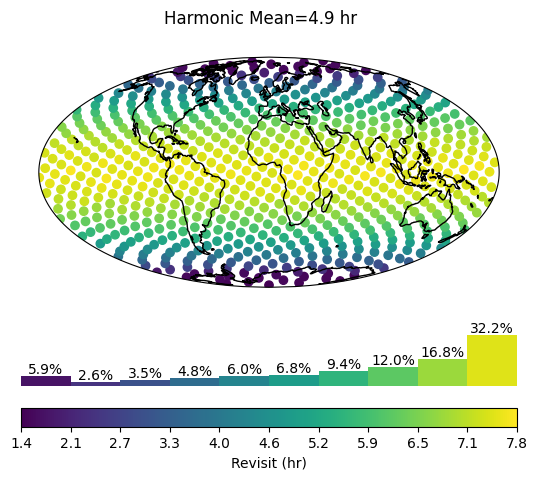

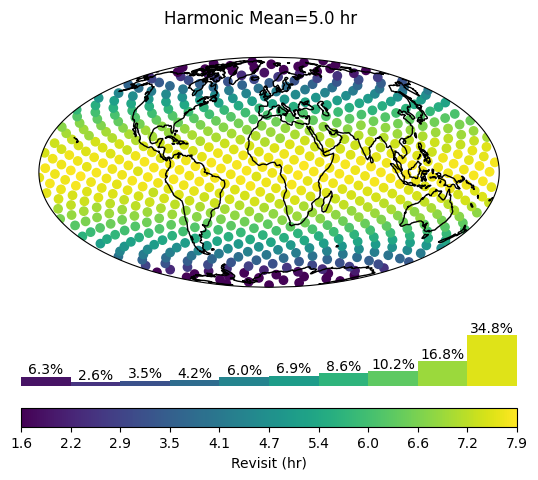

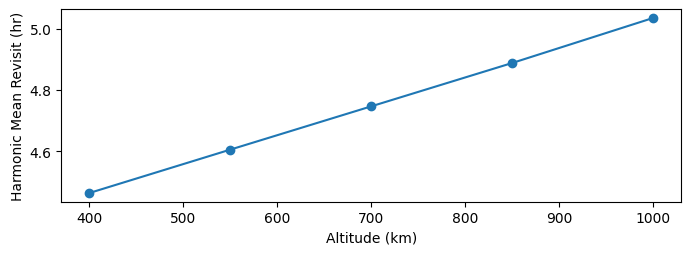

In [16]:
results = pd.DataFrame(
    [
        revisit_analysis(start, timedelta(days=30), design, points)
        for design in [
            program_of_record(altitude=alt)
            for alt in [400e3, 550e3, 700e3, 850e3, 1000e3]
        ]
    ]
)

results["altitude"] = results.apply(lambda r: r.satellites[0].orbit.altitude, axis=1)

display(results)

fig, ax = plt.subplots(figsize=(8, 2.5))
ax.plot(results["altitude"] / 1e3, results["revisit"], marker="o")
ax.set_xlabel("Altitude (km)")
ax.set_ylabel("Harmonic Mean Revisit (hr)")
plt.show()

### Constellation Size (13:30 LTAN) Sensitivity Analysis

,satellites,revisit,fig,number_satellites
0,[name='13:30 1' orbit=CircularOrbit(altitude=8...,4.887888,Figure(640x480),2
1,[name='13:30 1' orbit=CircularOrbit(altitude=8...,3.241551,Figure(640x480),3
2,[name='13:30 1' orbit=CircularOrbit(altitude=8...,2.429518,Figure(640x480),4


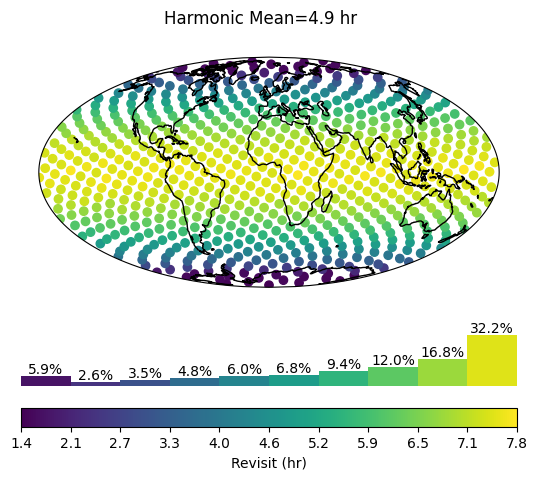

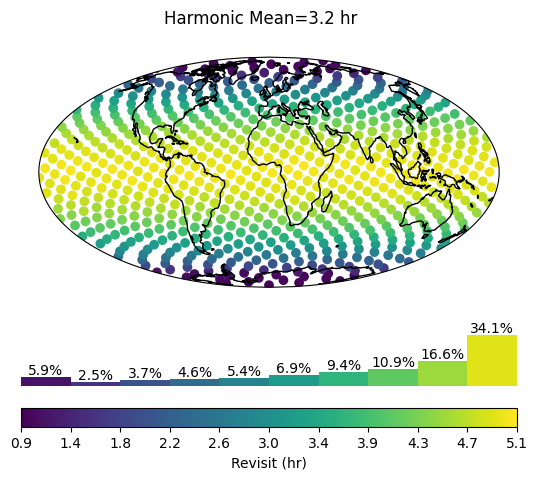

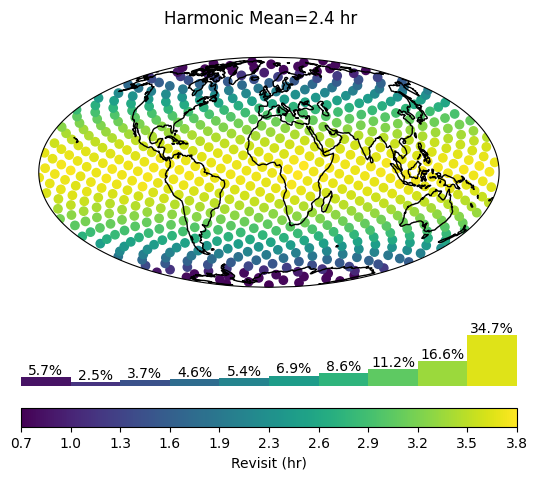

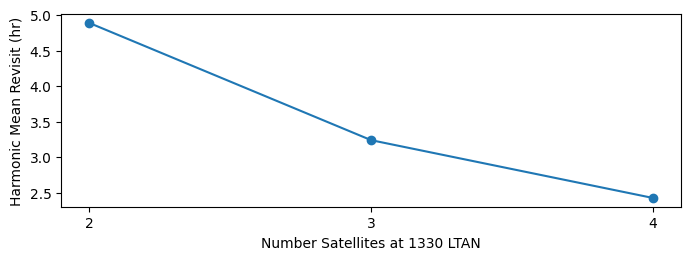

In [17]:
results = pd.DataFrame(
    [
        revisit_analysis(start, timedelta(days=30), design, points)
        for design in [
            program_of_record(num_satellites_1330=num_1330) for num_1330 in [2, 3, 4]
        ]
    ]
)

results["number_satellites"] = results.apply(lambda r: len(r.satellites), axis=1)

display(results)

fig, ax = plt.subplots(figsize=(8, 2.5))
ax.plot(results["number_satellites"], results["revisit"], marker="o")
ax.set_xlabel("Number Satellites at 1330 LTAN")
ax.set_xticks([2, 3, 4])
ax.set_ylabel("Harmonic Mean Revisit (hr)")
plt.show()

### Constellation Size (05:30 LTAN) Sensitivity Analysis

,satellites,revisit,fig,number_satellites
0,[name='13:30 1' orbit=CircularOrbit(altitude=8...,4.887888,Figure(640x480),0
1,[name='13:30 1' orbit=CircularOrbit(altitude=8...,3.270546,Figure(640x480),1
2,[name='13:30 1' orbit=CircularOrbit(altitude=8...,2.452488,Figure(640x480),2


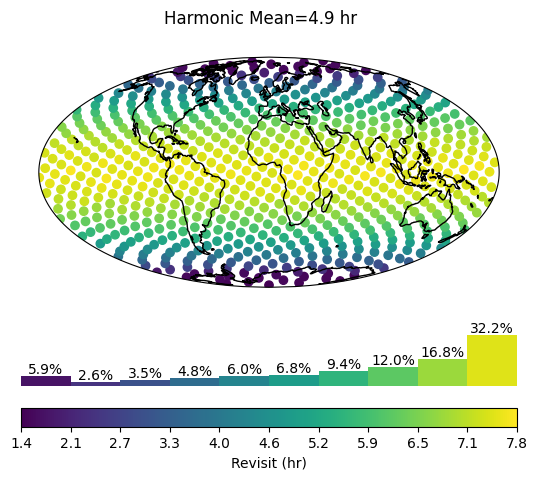

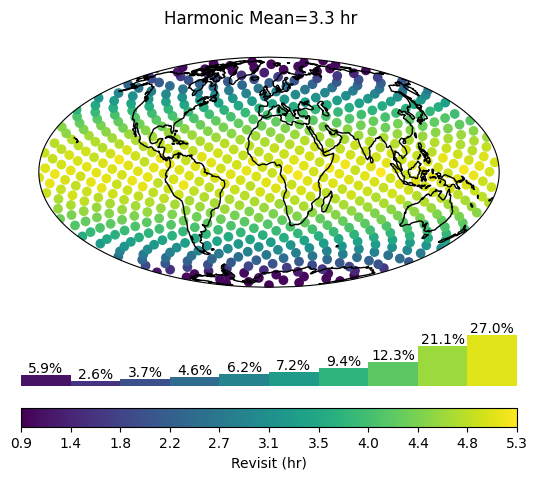

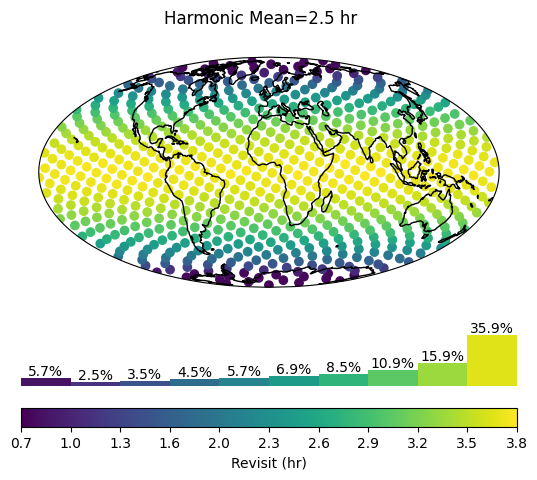

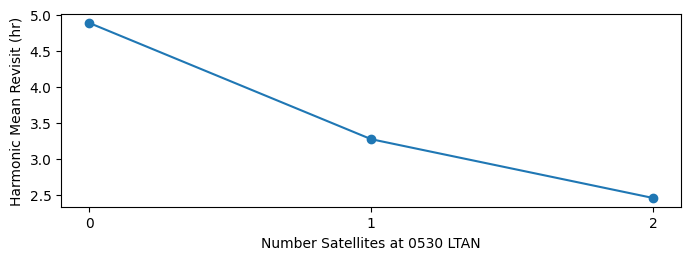

In [19]:
results = pd.DataFrame(
    [
        revisit_analysis(start, timedelta(days=30), design, points)
        for design in [
            program_of_record(num_satellites_0530=num_0530) for num_0530 in [0, 1, 2]
        ]
    ]
)

results["number_satellites"] = results.apply(lambda r: len(r.satellites) - 2, axis=1)

display(results)

fig, ax = plt.subplots(figsize=(8, 2.5))
ax.plot(results["number_satellites"], results["revisit"], marker="o")
ax.set_xlabel("Number Satellites at 0530 LTAN")
ax.set_xticks([0, 1, 2])
ax.set_ylabel("Harmonic Mean Revisit (hr)")
plt.show()

## LEO Replacement Analysis

The LEO replacement concept considers a 56-satellite constellation distributed among 7 planes oriented at 90 degrees inclination.

{'satellites': [Satellite(name='90/56/7/1 01', orbit=CircularOrbit(altitude=1000000.0, true_anomaly=0.0, epoch=datetime.datetime(2023, 9, 15, 0, 0, tzinfo=datetime.timezone.utc), type='circular', inclination=90.0, right_ascension_ascending_node=0.0), instruments=[Instrument(name='Microwave Sounder', field_of_regard=105.6865579144797, min_access_time=datetime.timedelta(seconds=2, microseconds=463361), req_self_sunlit=None, req_target_sunlit=None, access_time_fixed=True)], type='satellite'),
  Satellite(name='90/56/7/1 02', orbit=CircularOrbit(altitude=1000000.0, true_anomaly=45.0, epoch=datetime.datetime(2023, 9, 15, 0, 0, tzinfo=datetime.timezone.utc), type='circular', inclination=90.0, right_ascension_ascending_node=0.0), instruments=[Instrument(name='Microwave Sounder', field_of_regard=105.6865579144797, min_access_time=datetime.timedelta(seconds=2, microseconds=463361), req_self_sunlit=None, req_target_sunlit=None, access_time_fixed=True)], type='satellite'),
  Satellite(name='90/56

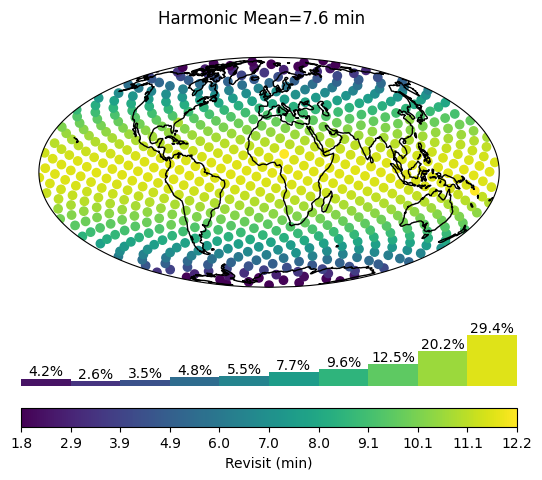

In [25]:
from tatc.schemas import CircularOrbit, Instrument, WalkerConstellation
from datetime import timedelta

orbit = CircularOrbit(
    altitude=1000e3,
    epoch=start,
    inclination=90,
)
sounder = Instrument(
    name="Microwave Sounder",
    field_of_regard=swath_width_to_field_of_regard(orbit.altitude, 3200000),
    min_access_time=timedelta(
        seconds=along_track_distance_to_access_time(
            orbit.altitude, orbit.inclination, 16000
        )
    ),
    access_time_fixed=True,
)
const = WalkerConstellation(
    name="90/56/7/1",
    orbit=orbit,
    instruments=[sounder],
    number_satellites=56,
    number_planes=7,
    relative_spacing=1,
)

revisit_analysis(
    start,
    timedelta(days=7),
    const.generate_members(),
    points,
    unit=timedelta(minutes=1),
)